In [ ]:
!pip install pydicom

In [ ]:
#https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

In [ ]:
%matplotlib inline

import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [ ]:
data_path = "/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01/CT"
output_path = working_path = "/content"
g = glob(data_path + '/*.dcm')

print("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print('\n'.join(g[:5]))

Total of 306 DICOM images.
First 5 filenames:
/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01/CT/CT1.2.752.243.1.1.20200703154328231.1200.81730.dcm
/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01/CT/CT1.2.752.243.1.1.20200703154328511.3200.77285.dcm
/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01/CT/CT1.2.752.243.1.1.20200703154328761.4600.26357.dcm
/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01/CT/CT1.2.752.243.1.1.20200703154328425.2700.84372.dcm
/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01/CT/CT1.2.752.243.1.1.20200703154328672.4100.64414.dcm


In [ ]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
# Loaded Exam Class with voxel_array_3d
id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [ ]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

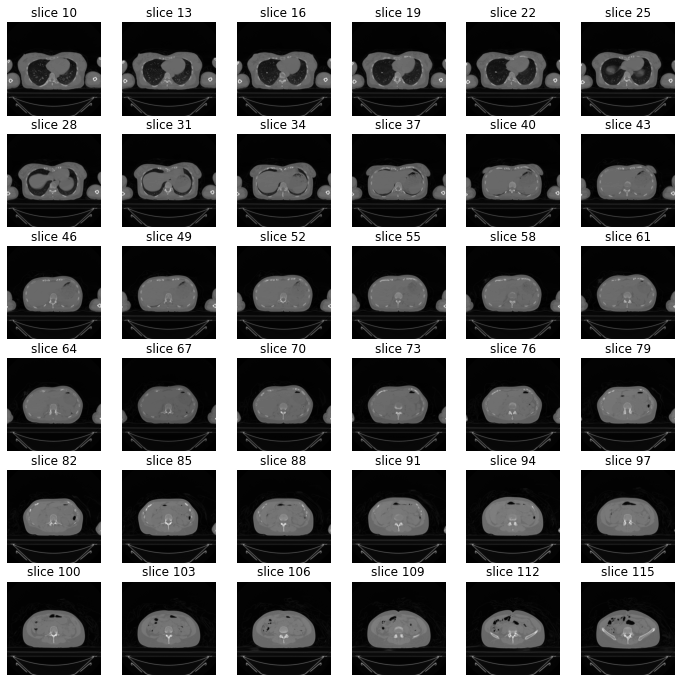

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (306, 512, 512)
Shape after resampling	 (612, 486, 486)


In [ ]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    fig.show()
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.9, 0.9, 0.9))
    plt.show()

In [ ]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
# reading in dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

In [ ]:
def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p, -300)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

In [ ]:
plot_3d(imgs_after_resamp)

Transposing surface
Calculating surface
Drawing


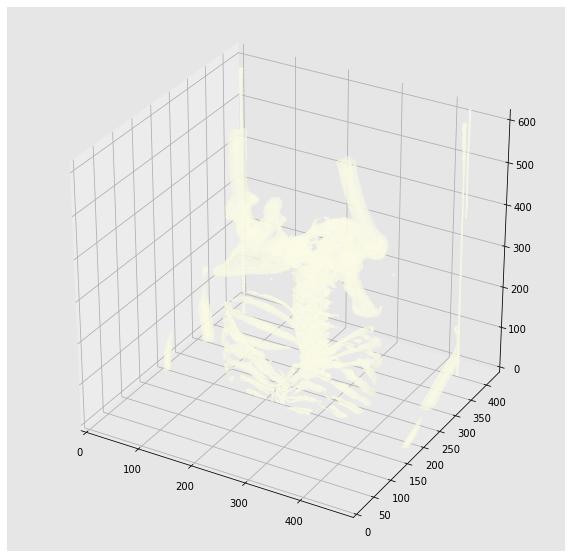

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)

Transposing surface
Calculating surface
Drawing


In [ ]:
!pip install SimpleITK

In [ ]:
!pip install dicompyler-core

     |████████████████████████████████| 35.5MB 110kB/s 


In [ ]:
# PACKAGE SOURCE CODE
# https://github.com/dicompyler/dicompyler-core

In [ ]:
# IMPORTS
from __future__ import division
from dicompylercore import dicomparser, dvh, dvhcalc
import sys
import numpy as np
import numpy.ma as ma
import matplotlib.path
import matplotlib.pyplot as plt

In [ ]:
def get_dvh(structure, dose, roi, limit=None, callback=None):
    from dicompylercore import dicomparser
    rtss = dicomparser.DicomParser(structure)
    rtdose = dicomparser.DicomParser(dose)
    structures = rtss.GetStructures()
    s = structures[roi]
    s['planes'] = rtss.GetStructureCoordinates(roi)
    s['thickness'] = rtss.CalculatePlaneThickness(s['planes'])
    hist = calculate_dvh(s, rtdose, limit, callback)
    return dvh.DVH(counts=hist,
                   bins=(np.arange(0, 2) if (hist.size == 1) else
                         np.arange(0, hist.size + 1) / 100),
                   dvh_type='differential',
                   dose_units='gy',
                   name=s['name']
                   ).cumulative

In [ ]:
def calculate_dvh(structure, dose, limit=None, callback=None):
    planes = structure['planes']
    logger.debug(
        "Calculating DVH of %s %s", structure['id'], structure['name'])

    # Create an empty array of bins to store the histogram in cGy
    # only if the structure has contour data or the dose grid exists
    if ((len(planes)) and ("PixelData" in dose.ds)):

        # Get the dose and image data information
        dd = dose.GetDoseData()
        id = dose.GetImageData()

        x, y = np.meshgrid(np.array(dd['lut'][0]), np.array(dd['lut'][1]))
        x, y = x.flatten(), y.flatten()
        dosegridpoints = np.vstack((x, y)).T

        maxdose = int(dd['dosemax'] * dd['dosegridscaling'] * 100)
        # Remove values above the limit (cGy) if specified
        if isinstance(limit, int):
            if (limit < maxdose):
                maxdose = limit
        hist = np.zeros(maxdose)
    else:
        return np.array([0])

    n = 0
    planedata = {}
    # Iterate over each plane in the structure
    for z, plane in iteritems(planes):
        # Get the dose plane for the current structure plane
        doseplane = dose.GetDoseGrid(z)
        planedata[z] = calculate_plane_histogram(
            plane, doseplane, dosegridpoints,
            maxdose, dd, id, structure, hist)
        n += 1
        if callback:
            callback(n, len(planes))
    # Volume units are given in cm^3
    volume = sum([p[1] for p in planedata.values()]) / 1000
    # Rescale the histogram to reflect the total volume
    hist = sum([p[0] for p in planedata.values()])
    hist = hist * volume / sum(hist)
    # Remove the bins above the max dose for the structure
    hist = np.trim_zeros(hist, trim='b')

    return hist

In [ ]:
def calculate_contour_dvh(mask, doseplane, maxdose, dd, id, structure):
    # Multiply the structure mask by the dose plane to get the dose mask
    mask = ma.array(doseplane * dd['dosegridscaling'] * 100, mask=~mask)
    # Calculate the differential dvh
    hist, edges = np.histogram(mask.compressed(),
                               bins=maxdose,
                               range=(0, maxdose))

    # Calculate the volume for the contour for the given dose plane
    vol = sum(hist) * ((id['pixelspacing'][0]) *
                       (id['pixelspacing'][1]) *
                       (structure['thickness']))
    return hist, vol

In [ ]:
def calculate_plane_histogram(plane, doseplane, dosegridpoints,
                              maxdose, dd, id, structure, hist):
    contours = [[x[0:2] for x in c['data']] for c in plane]

    # If there is no dose for the current plane, go to the next plane
    if not len(doseplane):
        return (np.arange(0, maxdose), 0)

    # Create a zero valued bool grid
    grid = np.zeros((dd['rows'], dd['columns']), dtype=np.uint8)

    # Calculate the histogram for each contour in the plane
    # and boolean xor to remove holes
    for i, contour in enumerate(contours):
        m = get_contour_mask(dd, id, dosegridpoints, contour)
        grid = np.logical_xor(m.astype(np.uint8), grid).astype(np.bool)

    hist, vol = calculate_contour_dvh(
        grid, doseplane, maxdose, dd, id, structure)
    return (hist, vol)

In [ ]:
def get_contour_mask(dd, id, dosegridpoints, contour):
    doselut = dd['lut']

    c = matplotlib.path.Path(list(contour))
    grid = c.contains_points(dosegridpoints)
    grid = grid.reshape((len(doselut[1]), len(doselut[0])))

    return grid

# DVH_TEST_01

1. Loading DICOM & Recording DVH Values

In [ ]:
import numpy as np
import pandas as pd
import math
from IPython.display import display, HTML
from scipy.interpolate import InterpolatedUnivariateSpline

font = {'size'   : 12}
matplotlib.rc('font', **font)
%cd /content/drive/My Drive/Colab Notebooks/UHN

files = ['Colon_Sigmoid', 'Bowel', 'Bladder_Wall', 'Rectum_Wall', 'x_CTVall_4500', 'x_PTVall_4500', 'Couch_Zephyr_Outer_Pelvis', 'Couch_Zephyr_Core_Pelvis', 'External_MBS']

/content/drive/My Drive/Colab Notebooks/UHN


In [ ]:
rtssfile = '/content/drive/My Drive/Colab Notebooks/UHN/RS1.2.752.243.1.1.20200703154333533.3230.70210.dcm'
rtdosefile = '/content/drive/My Drive/Colab Notebooks/UHN/RD1.2.752.243.1.1.20200703154334661.3270.33625.dcm'
RTss = dicomparser.DicomParser(rtssfile)
RTstructures = RTss.GetStructures()

calcdvhs = {}
for key, structure in RTstructures.items():
    calcdvhs[key] = dvhcalc.get_dvh(rtssfile, rtdosefile, key)
    if (key in calcdvhs) and (len(calcdvhs[key].counts) and calcdvhs[key].counts[0]!=0):
        print ('DVH Recorded: ' + structure['name'])

DVH Recorded: Colon_Sigmoid
DVH Recorded: Bowel
DVH Recorded: Bladder_Wall
DVH Recorded: Rectum_Wall
DVH Recorded: x_CTVall_4500
DVH Recorded: x_PTVall_4500
DVH Recorded: Couch_Zephyr_Outer_Pelvis
DVH Recorded: Couch_Zephyr_Core_Pelvis
DVH Recorded: External_MBS


1.1 Dose Slices Iteration

In [ ]:
### Not Working - Copied from PyCharms ###

def showdose(dose, meta, z):
    plt.imshow(GetDoseGrid(dose, meta, z) * meta['3004|000e'],
               vmin=0,
               vmax=float(dose.voxel_data_3d.max()) * meta['3004|000e'])


def GetDoseGrid(dose, meta, z=0, threshold=0.5):
    if meta['3004|000c']:
        z = float(z)
        origin = dose.image_origin[2]
        orientation = dose.image_orientation_patient[0]
        planes = orientation * np.array(list(map(float, meta['3004|000c'].split("\\")))) + origin
        frame = -1
        if np.amin(np.fabs(planes - z)) < threshold:  # If plane in array
            frame = np.argmin(np.fabs(planes - z))
            return dose.voxel_data_3d[frame]
        elif (z < np.amin(planes)) or (z > np.amax(planes)):  # If plane within dose grid boundaries
            return np.array([])
        else:  # Interpolate plane
            umin = np.fabs(planes - z)
            ub = np.argmin(umin)
            lmin = umin.copy()
            lmin[ub] = np.amax(umin)
            lb = np.argmin(lmin)
            fz = (z - planes[lb]) / (planes[ub] - planes[lb])
            plane = fz * dose.voxel_data_3d[ub] + (1.0 - fz) * dose.voxel_data_3d[lb]
            return plane
    else:
        return np.array([])



In [ ]:
rtdose = dicomparser.DicomParser(rtdosefile)

planes = \
    (np.array(rtdose.ds.GridFrameOffsetVector) \
    * rtdose.ds.ImageOrientationPatient[0]) \
    + rtdose.ds.ImagePositionPatient[2]
dd = rtdose.GetDoseData()

from ipywidgets import FloatSlider, interactive
w = FloatSlider(
    value=0.56,
    min=planes[0],
    max=planes[-1],
    step=np.diff(planes)[0],
    description='Slice Position (mm):',
)

def showdose(z):
    plt.imshow(rtdose.GetDoseGrid(z) * dd['dosegridscaling'],
               vmin=0,
               vmax=dd['dosemax'] * dd['dosegridscaling'])

interactive(showdose, z=w)

interactive(children=(FloatSlider(value=-48.5, description='Slice Position (mm):', max=-48.5, min=-663.5, step…

2.1 Plotting Calculated DVH (Cumulative)

In [ ]:
# Plotting DVH for ONE STRUCTURE
df_test = pd.read_excel("Rectum_Wall.xlsx")
df_test[['Dose', 'Rectum_Wall_RAYSTATION']] = pd.DataFrame(df_test['Test'].str.split('\t').tolist())
del df_test['Test']
df_test = df_test.astype(float)

x = df_test["Dose"]
y = df_test['Rectum_Wall_RAYSTATION']
z = np.linspace(0, 4654, 4655)
interp = np.interp(z, x, y)
interp

,Dose,Rectum_Wall_RAYSTATION
0,0.000,100.000
1,20.000,100.000
2,40.000,100.000
3,60.000,100.000
4,80.000,100.000
...,...,...
331,4620.000,0.334
332,4640.000,0.212
333,4660.000,0.130
334,4672.625,0.000


In [ ]:
RTstructures.items()

dict_items([(11, {'id': 11, 'name': 'Colon_Sigmoid', 'type': 'ORGAN', 'color': array([165, 161,  55]), 'empty': False}), (12, {'id': 12, 'name': 'Bowel', 'type': 'ORGAN', 'color': array([255,   0, 128]), 'empty': False}), (17, {'id': 17, 'name': 'Bladder_Wall', 'type': 'ORGAN', 'color': array([255, 255, 128]), 'empty': False}), (18, {'id': 18, 'name': 'Rectum_Wall', 'type': 'ORGAN', 'color': array([128,  64,  64]), 'empty': False}), (45, {'id': 45, 'name': 'x_CTVall_4500', 'type': 'CONTROL', 'color': array([  0, 255,  48]), 'empty': False}), (46, {'id': 46, 'name': 'x_PTVall_4500', 'type': 'CONTROL', 'color': array([  0,  80, 255]), 'empty': False}), (62, {'id': 62, 'name': 'Couch_Zephyr_Outer_Pelvis', 'type': 'SUPPORT', 'color': array([128, 128, 128]), 'empty': False}), (64, {'id': 64, 'name': 'Couch_Zephyr_Core_Pelvis', 'type': 'SUPPORT', 'color': array([105, 105, 105]), 'empty': False}), (70, {'id': 70, 'name': 'External_MBS', 'type': 'NONE', 'color': array([255, 215,   0]), 'empty'

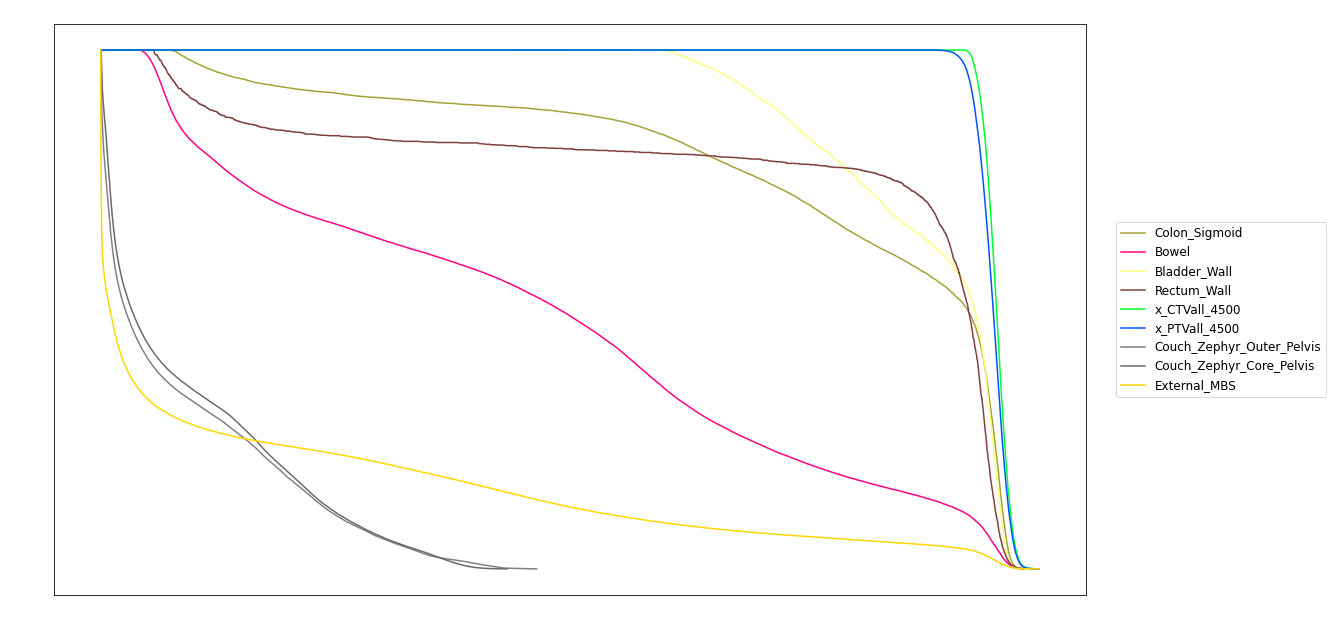

In [ ]:
for key, structure in RTstructures.items():
    if (key in calcdvhs) and (len(calcdvhs[key].counts) and calcdvhs[key].counts[0]!=0):
        plt.plot(calcdvhs[key].counts * 100/calcdvhs[key].counts[0], '-',
                color=dvhcalc.np.array(structure['color'], dtype=float) / 255, 
                label=structure['name'])
                
plt.title('Cumulative DVH for DVH_Test_01', color='w')
plt.xlabel('Dose [cGy]', color='w')
plt.ylabel('Percentage Volume [%]', color='w')
plt.tick_params(colors='w')
plt.legend(loc='right', borderaxespad=-20)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01_Calculated_DVH_Cumulative.png')

#plt.plot(interp)   # One Structure

2.2 Plotting Calculated DVH (Differential)

In [ ]:
calcdvhs

{11: DVH(cumulative, 4669 bins: [0.0:46.69] Gy, volume: 264.7124999999942 cm3, name: 'Colon_Sigmoid', rx_dose: 0 Gy),
 12: DVH(cumulative, 4659 bins: [0.0:46.59] Gy, volume: 719.8000000000014 cm3, name: 'Bowel', rx_dose: 0 Gy),
 17: DVH(cumulative, 4640 bins: [0.0:46.4] Gy, volume: 74.07500000000128 cm3, name: 'Bladder_Wall', rx_dose: 0 Gy),
 18: DVH(cumulative, 4655 bins: [0.0:46.55] Gy, volume: 28.599999999999575 cm3, name: 'Rectum_Wall', rx_dose: 0 Gy),
 35: DVH(cumulative, 1 bins: [0:1] Gy, volume: 0 cm3, name: 'CT SETUP', rx_dose: 0 Gy, *Notes: Empty DVH),
 36: DVH(cumulative, 1 bins: [0:1] Gy, volume: 0 cm3, name: 'ISO_A', rx_dose: 0 Gy, *Notes: Empty DVH),
 41: DVH(cumulative, 1 bins: [0:1] Gy, volume: 0 cm3, name: 'BB_ANT', rx_dose: 0 Gy, *Notes: Empty DVH),
 42: DVH(cumulative, 1 bins: [0:1] Gy, volume: 0 cm3, name: 'BB_RT', rx_dose: 0 Gy, *Notes: Empty DVH),
 45: DVH(cumulative, 4739 bins: [0.0:47.39] Gy, volume: 694.8374999999994 cm3, name: 'x_CTVall_4500', rx_dose: 0 Gy),
 

DVH Recorded: Colon_Sigmoid
DVH Recorded: Bowel
DVH Recorded: Bladder_Wall
DVH Recorded: Rectum_Wall
DVH Recorded: x_CTVall_4500
DVH Recorded: x_PTVall_4500
DVH Recorded: Couch_Zephyr_Outer_Pelvis
DVH Recorded: Couch_Zephyr_Core_Pelvis


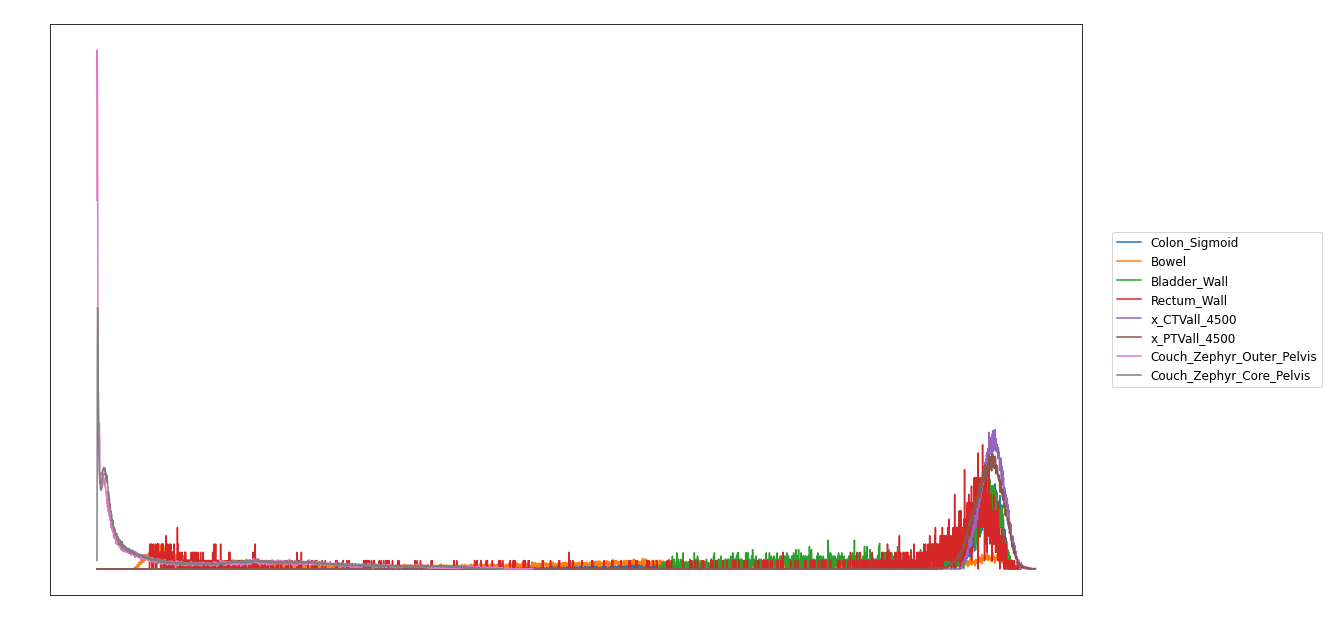

In [ ]:
calcdvhs = {}
for key, structure in RTstructures.items():
    calcdvhs[key] = dvhcalc.get_dvh(rtssfile, rtdosefile, key)
    if key != 70:
        if (key in calcdvhs) and (len(calcdvhs[key].counts) and calcdvhs[key].counts[0]!=0):
            print ('DVH Recorded: ' + structure['name'])
            calcdvhs[key].relative_volume.differential.plot()

plt.title('Differential DVH for DVH_Test_01', color='w')
plt.xlabel('Dose [Gy]', color='w')
plt.ylabel('Volume [%]', color='w')
plt.tick_params(colors='w')
plt.legend(loc='right', borderaxespad=-20)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01_Calculated_DVH_Differential.png')

3. Comparing with interpolated RayStation DVH Data

In [ ]:
column_names = ['Dose']
df1 = pd.DataFrame(columns=column_names)
df1['Dose'] = [i for i in range(0, 4739)]
for key, structure in RTstructures.items():
    if (key in calcdvhs) and (len(calcdvhs[key].counts) and calcdvhs[key].counts[0]!=0):
        df1[str(key)] = (pd.DataFrame(np.array(calcdvhs[key].counts * 100/calcdvhs[key].counts[0])))
        column_names.append(structure['name'])
df1.columns = column_names
df1[4655:]

,Dose,Colon_Sigmoid,Bowel,Bladder_Wall,Rectum_Wall,x_CTVall_4500,x_PTVall_4500,Couch_Zephyr_Outer_Pelvis,Couch_Zephyr_Core_Pelvis,External_MBS
4655,4655,0.042499,0.003473,NaN,NaN,0.595463,0.456933,NaN,NaN,0.016763
4656,4656,0.037777,0.003473,NaN,NaN,0.573875,0.435174,NaN,NaN,0.015914
4657,4657,0.037777,0.003473,NaN,NaN,0.539695,0.413415,NaN,NaN,0.015101
4658,4658,0.033055,0.001737,NaN,NaN,0.514509,0.393635,NaN,NaN,0.014252
4659,4659,0.033055,NaN,NaN,NaN,0.492921,0.367920,NaN,NaN,0.013333
...,...,...,...,...,...,...,...,...,...,...
4734,4734,NaN,NaN,NaN,NaN,0.005397,0.002967,NaN,NaN,0.000106
4735,4735,NaN,NaN,NaN,NaN,0.003598,0.001978,NaN,NaN,0.000071
4736,4736,NaN,NaN,NaN,NaN,0.003598,0.001978,NaN,NaN,0.000071
4737,4737,NaN,NaN,NaN,NaN,0.001799,0.000989,NaN,NaN,0.000035


3.1 Percentage Volume vs. Dose Difference




In [ ]:
def plot_dose_differences(file_list):
    for each_file in file_list:
        each_file_ext = each_file + '.xlsx'

        percentages = np.linspace(0, 100, 1001)
        
        df_temp = df1[['Dose',each_file]].copy()
        df_temp.dropna(inplace=True)
        df_temp.drop_duplicates(subset=each_file, keep='last', inplace=True)

        calculated_doses = np.flip(np.array(df_temp['Dose']))
        calculated_percentage_volumes = np.flip(np.array(df_temp[each_file]))
        func = InterpolatedUnivariateSpline(calculated_percentage_volumes, calculated_doses, k=1)
        calculated_interpolated = func(percentages)

        df2 = pd.read_excel(each_file_ext)
        df2[['Dose', each_file]] = pd.DataFrame(df2['Test'].str.split('\t').tolist())
        del df2['Test']
        df2 = df2.astype(float)

        df_temp2 = df2[['Dose',each_file]].copy()
        df_temp2.dropna(inplace=True)
        df_temp2.drop_duplicates(subset=each_file, keep='last', inplace=True)

        raystation_doses = np.flip(np.array(df_temp2['Dose']))
        raystation_percentage_volumes = np.flip(np.array(df_temp2[each_file]))
        func2 = InterpolatedUnivariateSpline(raystation_percentage_volumes, raystation_doses, k=1)
        raystation_interpolated = func2(percentages)

        dose_differences = raystation_interpolated - calculated_interpolated

        df_plot = pd.DataFrame(dose_differences, percentages)

        plt.plot(df_plot)
        plt.title('Dose Difference b/w Calculated DVH Values & RayStation DVH Values', color='w', fontsize=18)
        plt.xlabel('Percentage Volume [%]', color='w', fontsize=16)
        plt.ylabel('Dosage [cGy]', color='w', fontsize=16)
        plt.tick_params(colors='w')
        plt.legend(labels=files, loc='right', borderaxespad=-20)
        
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01_DVH_Dose_Tolerance.png')

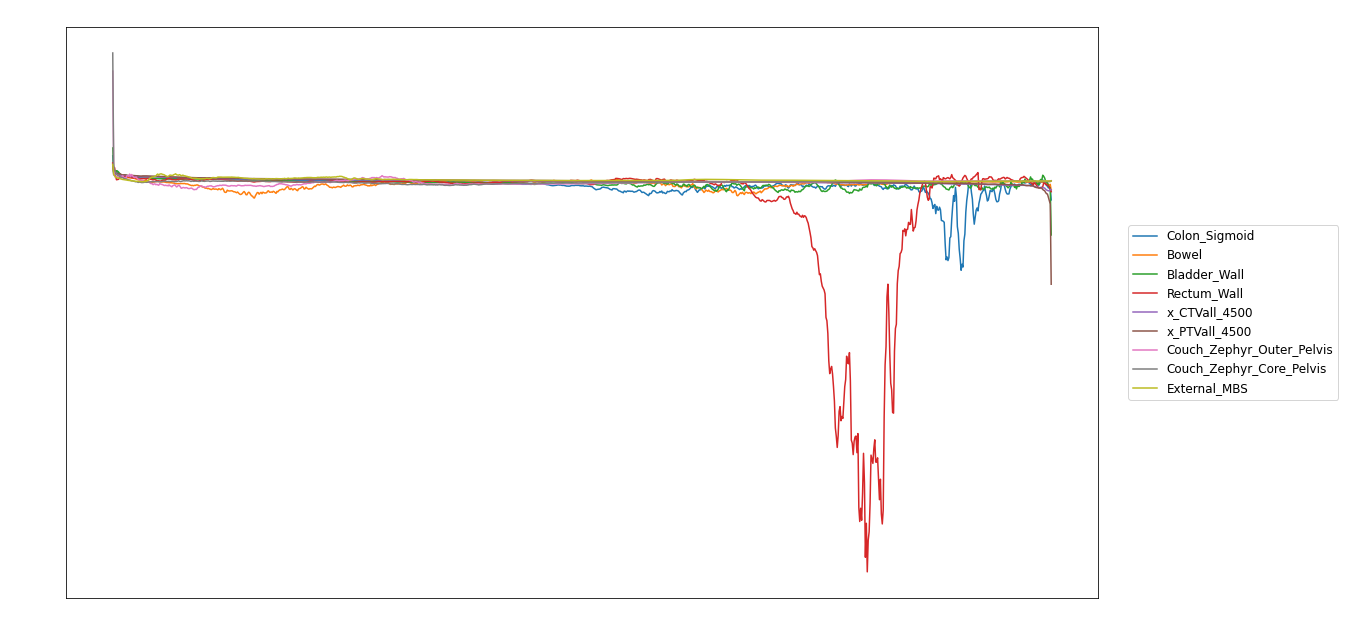

In [ ]:
plot_dose_differences(files)

3.2 Samples vs. Percentage Difference

In [ ]:
files_without_External_MBS = ['Colon_Sigmoid', 'Bowel', 'Bladder_Wall', 'Rectum_Wall', 'x_CTVall_4500', 'x_PTVall_4500', 'Couch_Zephyr_Outer_Pelvis', 'Couch_Zephyr_Core_Pelvis']

In [ ]:
def plot_percentage_differences(file_list, print_External_MBS):
    for each_file in file_list:
        each_file_ext = each_file + '.xlsx'
        df2 = pd.read_excel(each_file_ext)
        df2[['Dose', each_file]] = pd.DataFrame(df2['Test'].str.split('\t').tolist())
        del df2['Test']
        df2 = df2.astype(float)

        if each_file == 'External_MBS' and print_External_MBS:
            print(df2[10:20])

        x = list(df2['Dose'])
        x_trunc = []
        for i in range(0, len(x)):
            x_trunc.append(round(x[i]))
        x_trunc = [x for x in x_trunc if x <= 4738]
        len(x_trunc)

        dict_df2 = {}
        dict_df2['Dose'] = x_trunc
        listdf2 = []
        for i in range(0, len(x_trunc)):
            listdf2.append(df1.loc[df1['Dose'] == x_trunc[i], each_file].item())
        dict_df2[each_file] = listdf2

        df3 = pd.DataFrame.from_dict(dict_df2)

        df3[each_file + ' Percentage Volume Difference'] = df3.drop_duplicates(['Dose', each_file])[each_file]

        if each_file == 'External_MBS' and print_External_MBS:
            print(df3[10:20])
    
        series = df2[each_file] - df3[each_file]
    
        df4 = series.to_frame()
        df4 = df4.dropna()

        plt.plot(df4)
        plt.title('Difference b/w Calculated DVH Percentage Volume & RayStation DVH Percentage Volume', color='w', fontsize=18)
        plt.xlabel('Sample', color='w', fontsize=16)
        plt.ylabel('Percentage Volume Difference [%]', color='w', fontsize=16)
        plt.tick_params(colors='w')
        plt.legend(labels=files, loc='right', borderaxespad=-20)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/UHN/DVH_Test_01_DVH_Percentage_Volume_Tolerance.png')

     Dose  External_MBS
10  0.000          90.0
11  0.000          89.0
12  0.000          88.0
13  0.040          87.0
14  0.288          86.0
15  0.535          85.0
16  0.782          84.0
17  1.030          83.0
18  1.277          82.0
19  1.524          81.0
    Dose  External_MBS  External_MBS Percentage Volume Difference
10     0    100.000000                                        NaN
11     0    100.000000                                        NaN
12     0    100.000000                                        NaN
13     0    100.000000                                        NaN
14     0    100.000000                                        NaN
15     1     82.630831                                  82.630831
16     1     82.630831                                        NaN
17     1     82.630831                                        NaN
18     1     82.630831                                        NaN
19     2     76.542073                                  76.542073


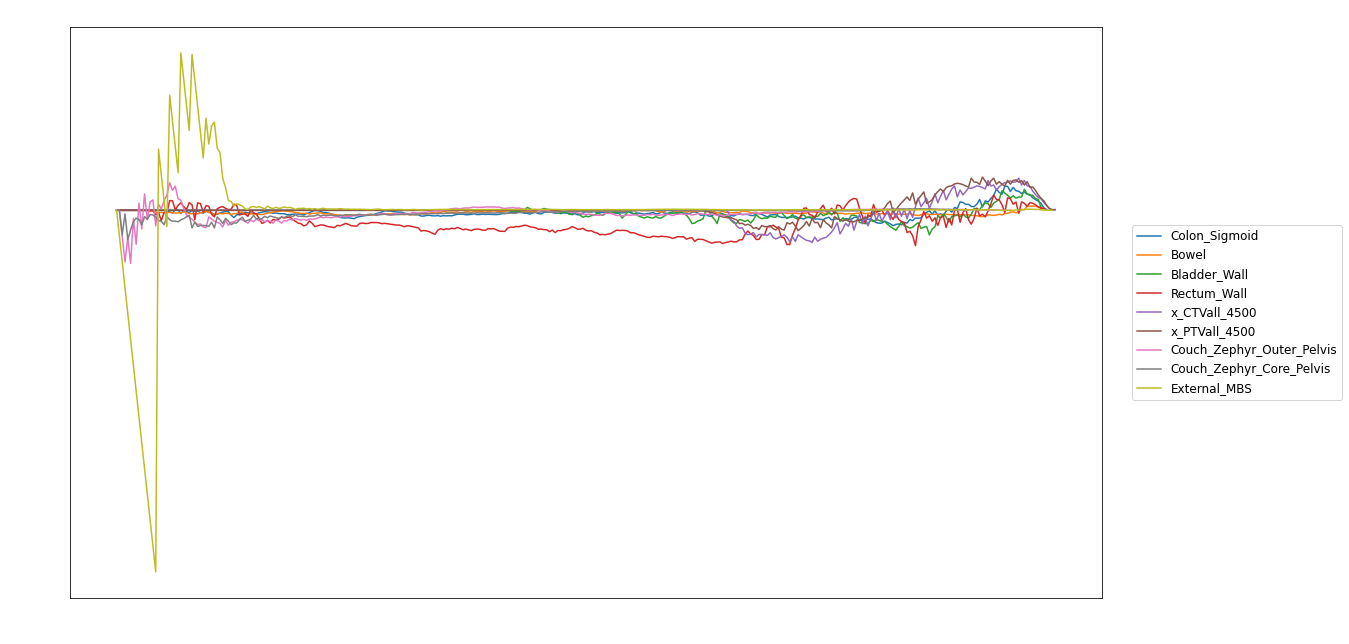

In [ ]:
plot_percentage_differences(files, print_External_MBS=True)